In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

In [26]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

## Step 1: Map classical inputs to a quantum problem

In [3]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [21]:
hamiltonian

SparsePauliOp(['YZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[ 0.398 +0.j, -0.398 +0.j, -0.0113+0.j,  0.181 +0.j])

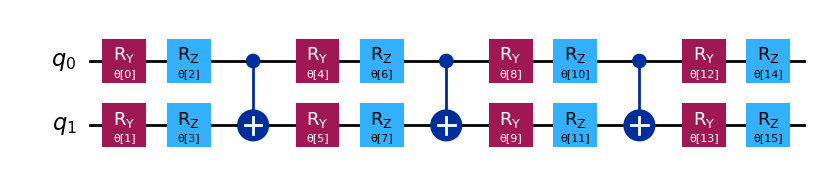

In [4]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [5]:
num_params = ansatz.num_parameters
num_params

16

## Step 2: Optimize problem for quantum execution.

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

In [22]:
ansatz_isa.layout

TranspileLayout(initial_layout=Layout({
26: Qubit(QuantumRegister(2, 'q'), 0),
16: Qubit(QuantumRegister(2, 'q'), 1),
0: Qubit(QuantumRegister(125, 'ancilla'), 0),
1: Qubit(QuantumRegister(125, 'ancilla'), 1),
2: Qubit(QuantumRegister(125, 'ancilla'), 2),
3: Qubit(QuantumRegister(125, 'ancilla'), 3),
4: Qubit(QuantumRegister(125, 'ancilla'), 4),
5: Qubit(QuantumRegister(125, 'ancilla'), 5),
6: Qubit(QuantumRegister(125, 'ancilla'), 6),
7: Qubit(QuantumRegister(125, 'ancilla'), 7),
8: Qubit(QuantumRegister(125, 'ancilla'), 8),
9: Qubit(QuantumRegister(125, 'ancilla'), 9),
10: Qubit(QuantumRegister(125, 'ancilla'), 10),
11: Qubit(QuantumRegister(125, 'ancilla'), 11),
12: Qubit(QuantumRegister(125, 'ancilla'), 12),
13: Qubit(QuantumRegister(125, 'ancilla'), 13),
14: Qubit(QuantumRegister(125, 'ancilla'), 14),
15: Qubit(QuantumRegister(125, 'ancilla'), 15),
17: Qubit(QuantumRegister(125, 'ancilla'), 16),
18: Qubit(QuantumRegister(125, 'ancilla'), 17),
19: Qubit(QuantumRegister(125, 'ancill

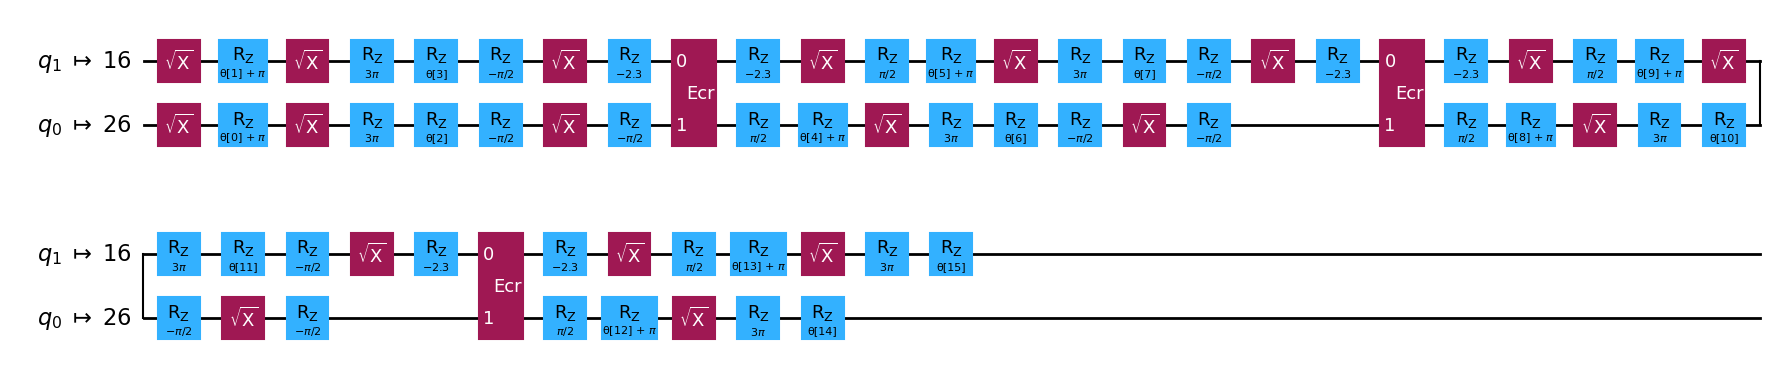

In [8]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [9]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3: Execute using Qiskit Primitives.

In [11]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [13]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.20676222, 4.0404815 , 4.35719639, 4.20366945, 4.45335322,
       4.46373336, 3.11632666, 2.23516973, 1.77471593, 4.81239106,
       2.07464353, 4.9020444 , 4.59774402, 4.91747008, 1.1150743 ,
       2.04272165])

In [14]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: 0.14922586116758643]
Iters. done: 2 [Current cost: -0.11612803571621408]
Iters. done: 3 [Current cost: 0.07002776280206445]
Iters. done: 4 [Current cost: -0.13386988850633055]
Iters. done: 5 [Current cost: -0.3302387656462088]
Iters. done: 6 [Current cost: -0.10234731983003965]
Iters. done: 7 [Current cost: -0.13772207900026967]
Iters. done: 8 [Current cost: -0.45905039527309566]
Iters. done: 9 [Current cost: -0.445916509386791]
Iters. done: 10 [Current cost: -0.36337138067990404]
Iters. done: 11 [Current cost: -0.42997434693744946]
Iters. done: 12 [Current cost: -0.28915363465327376]
Iters. done: 13 [Current cost: -0.35322293062687277]
Iters. done: 14 [Current cost: -0.5704129149833769]
Iters. done: 15 [Current cost: -0.47988316089181043]
Iters. done: 16 [Current cost: -0.46759465876835415]
Iters. done: 17 [Current cost: -0.24320415638696258]
Iters. done: 18 [Current cost: -0.588662767522721]
Iters. done: 19 [Current cost: -0.44708847005466235]
Iters. don

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [19]:
res

NameError: name 'res' is not defined

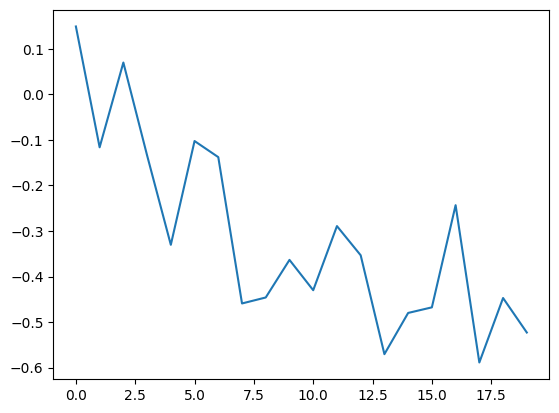

In [20]:
import matplotlib.pyplot as plt
cost = [0.14922586116758643, -0.11612803571621408, 0.07002776280206445, -0.13386988850633055, -0.3302387656462088, -0.10234731983003965, -0.13772207900026967, -0.45905039527309566, -0.445916509386791, -0.36337138067990404, -0.42997434693744946, -0.28915363465327376, -0.35322293062687277, -0.5704129149833769, -0.47988316089181043, -0.46759465876835415, -0.24320415638696258, -0.588662767522721, -0.44708847005466235, -0.5228542313152235]
plt.plot(cost)

## Step 4: Post-process, return result in classical format.

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
cost_history_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [23]:
cost_history_dict

{'prev_vector': array([3.05888996, 4.43727613, 5.39903657, 5.66676143, 3.91592233,
        4.00972591, 4.42010001, 2.20419641, 1.54907842, 4.74382172,
        1.6739801 , 4.65247405, 5.86036756, 4.70397595, 0.87260049,
        1.27107314]),
 'iters': 20,
 'cost_history': [0.14922586116758643,
  -0.11612803571621408,
  0.07002776280206445,
  -0.13386988850633055,
  -0.3302387656462088,
  -0.10234731983003965,
  -0.13772207900026967,
  -0.45905039527309566,
  -0.445916509386791,
  -0.36337138067990404,
  -0.42997434693744946,
  -0.28915363465327376,
  -0.35322293062687277,
  -0.5704129149833769,
  -0.47988316089181043,
  -0.46759465876835415,
  -0.24320415638696258,
  -0.588662767522721,
  -0.44708847005466235,
  -0.5228542313152235]}

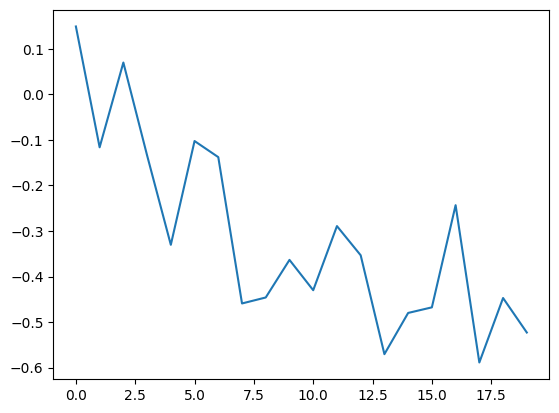

In [25]:
plt.plot(cost_history_dict['cost_history'])